# SHTOOLS: dealing with spherical harmonics

The webpage is at http://shtools.ipgp.fr/. I used the Fortran
version before, but not the Python bindings.

## Installation

First, you will need fftw installed. On my Mac, I did:

    curl http://www.fftw.org/fftw-3.3.4.tar.gz -o fftw-3.3.4.tar.gz
    tar -xzvf fftw-3.3.4.tar.gz
    cd fftw-3.3.4
    ./configure --enable-threads
    sudo make install
    
which compiles fftw3 and puts the result in `/usr/local/lib`. You then need to build 
SHTOOLS with python support. I grabbed a copy from the git repository:

    git clone git@github.com:SHTOOLS/SHTOOLS.git
    cd SHTOOLS/
    # edit the Makefile (see below)
    make # Now builds the python wrapper too
    
after editing the Makefile to point at `/usr/local/lib` changing:

    $(F2PY) -I$(INCDIR) -L$(LIBDIR) --f90flags="$(F95FLAGS)" \
    
to: 

    $(F2PY) -I$(INCDIR) -L$(LIBDIR) -L/usr/local/lib --f90flags="$(F95FLAGS)" \
    
(which is a bit naff - there should be an environment variable to set this).

We need to make sure that pyshtools is avalable to run this notebook. One way to 
do this is to start the notebook server with:

    export PYTHONPATH="/Users/earawa/Code/SHTOOLS"
    ipython notebook
    
This process could be improved, but it seems to work here.

## An example

I wanted to replace some (rather crusty) Fortran 
with a python implementation. The idea is to compare
CMB anisotropy from some of my models with global 
tomography.

In [1]:
import pyshtools as shtools

Loading SHTOOLS documentation


In [2]:
p_limit = 0.95
for l in range(8):
    for c in range(1,10000):
        corel = float(c)/10000.0
        p = shtools.SHConfidence(l, corel)
        if (p > p_limit):
            print ("At {} confidence, two degree {} "
                   "spherical harmonic coefficents are " 
                   "correlated if the correlation "
                   "coefficent is greater than {}").format(p_limit, l, corel)
            break
            

At 0.95 confidence, two degree 0 spherical harmonic coefficents are correlated if the correlation coefficent is greater than 0.9501
At 0.95 confidence, two degree 1 spherical harmonic coefficents are correlated if the correlation coefficent is greater than 0.9501
At 0.95 confidence, two degree 2 spherical harmonic coefficents are correlated if the correlation coefficent is greater than 0.8115
At 0.95 confidence, two degree 3 spherical harmonic coefficents are correlated if the correlation coefficent is greater than 0.7068
At 0.95 confidence, two degree 4 spherical harmonic coefficents are correlated if the correlation coefficent is greater than 0.6319
At 0.95 confidence, two degree 5 spherical harmonic coefficents are correlated if the correlation coefficent is greater than 0.576
At 0.95 confidence, two degree 6 spherical harmonic coefficents are correlated if the correlation coefficent is greater than 0.5325
At 0.95 confidence, two degree 7 spherical harmonic coefficents are correlate

In [3]:
!ls

DataProcessing.ipynb
Ellip_correct.ipynb
FitCMB.ipynb
ISC_2_pandas.ipynb
Odd_ttimes.ipynb
ProcessISC.ipynb
README.md
S362WMANI-Xipercent.txt
SHTOOLS.ipynb
StationStatics.ipynb
TX2008.V2.T9.6.topo.pretexture.P100.Xi.dat
Tomocor.ipynb
ak135.1D_vp
basemap.ipynb
dt_from_dCMB.ipynb
input.latlon_tomo_predict
processed_data.pkl
taup.ipynb
vdh3D_1999


In [4]:
!head S362WMANI-Xipercent.txt

-180.00 -90.00 1.68544919804
-175.00 -90.00 1.68544919804
-170.00 -90.00 1.68544919804
-165.00 -90.00 1.68544919804
-160.00 -90.00 1.68544919804
-155.00 -90.00 1.68544919804
-150.00 -90.00 1.68544919804
-145.00 -90.00 1.68544919804
-140.00 -90.00 1.68544919804
-135.00 -90.00 1.68544919804


In [5]:
import numpy as np
data = np.loadtxt('S362WMANI-Xipercent.txt')
# note that data[:,0] is the longitude
# data[:,1] is the latitude and data[:,2]
# is the anisotropy.

In [6]:
# Find the spherical harmonic coefficents up to degree 8
cilm, chi2 = shtools.SHExpandLSQ(data[:,2], data[:,0], data[:,1], 8)

In [7]:
cilm.shape

(2, 9, 9)

In [8]:
power_spectrum = shtools.SHPowerSpectrum(cilm, 8)

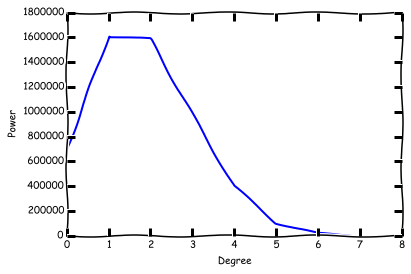

In [9]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

with plt.xkcd():
    plt.plot(power_spectrum)
    plt.xlabel("Degree")
    plt.ylabel("Power")

In [10]:
print cilm[1,:,0]

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]


//anaconda/lib/python2.7/site-packages/matplotlib/tri/triangulation.py:110: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  self._neighbors)


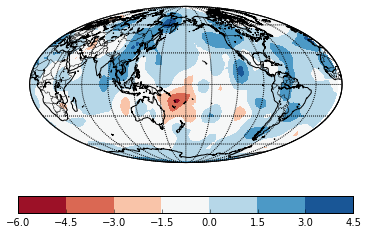

In [11]:
from mpl_toolkits.basemap import Basemap

fig = plt.figure()
axis = fig.add_subplot(1,1,1)

map = Basemap(projection='moll', lon_0=180.0,
                  resolution='c', area_thresh=1000., ax=axis)
map.drawcoastlines()
map.drawcountries()
map.drawmapboundary()
map.drawmeridians(np.arange(-180,180,30),labels=[0,0,0,0])
map.drawparallels(np.arange(-90,90,30),labels=[0,0,0,0])

# convert lat and lon to map ref. system
lon_m, lat_m = map(data[:,0], data[:,1])
m_dats = data[:,2]

conts = map.contourf(lon_m, lat_m, m_dats, tri=True, cmap=plt.cm.RdBu,)
fig.colorbar(conts, ax=axis, orientation='horizontal')

plt.show()

In [12]:
filtered_data = np.zeros_like(data[:,2])
# Bit poo to have to put this in a loop
for i in range(data[:,2].size):
    filtered_data[i] = shtools.MakeGridPoint(cilm, data[i,0], data[i,1])

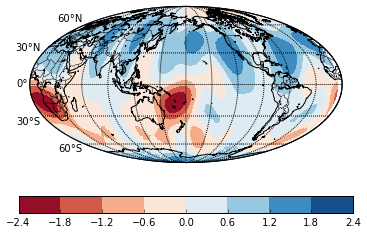

In [13]:
fig = plt.figure()
axis = fig.add_subplot(1,1,1)

map = Basemap(projection='moll', lon_0=180.0,
                  resolution='c', area_thresh=1000., ax=axis)
map.drawcoastlines()
map.drawcountries()
map.drawmapboundary()
map.drawmeridians(np.arange(-180,180,30),labels=[0,0,0,0])
map.drawparallels(np.arange(-90,90,30),labels=[1,0,0,0])

# convert lat and lon to map ref. system
lon_m, lat_m = map(data[:,0], data[:,1])

conts = map.contourf(lon_m, lat_m, filtered_data, tri=True, cmap=plt.cm.RdBu,)
fig.colorbar(conts, ax=axis, orientation='horizontal')

plt.show()

In [15]:
!ls

DataProcessing.ipynb
Ellip_correct.ipynb
FitCMB.ipynb
ISC_2_pandas.ipynb
Odd_ttimes.ipynb
ProcessISC.ipynb
README.md
S362WMANI-Xipercent.txt
SHTOOLS.ipynb
StationStatics.ipynb
TX2008.V2.T9.6.topo.pretexture.P100.Xi.dat
Tomocor.ipynb
ak135.1D_vp
basemap.ipynb
dt_from_dCMB.ipynb
input.latlon_tomo_predict
processed_data.pkl
taup.ipynb
vdh3D_1999


In [14]:
model_data = np.loadtxt('TX2008.V2.T9.6.topo.pretexture.P100.Xi.dat')
# note that model_data[:,0] is the latitude
# data[:,1] is the longitude and data[:,3]
# is the anisotropy. This is different to 
# data, above! NB: model_data[2] is the depth!

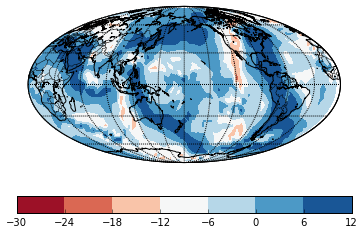

In [16]:
fig = plt.figure()
axis = fig.add_subplot(1,1,1)

map = Basemap(projection='moll', lon_0=180.0,
                  resolution='c', area_thresh=1000., ax=axis)
map.drawcoastlines()
map.drawcountries()
map.drawmapboundary()
map.drawmeridians(np.arange(-180,180,30),labels=[0,0,0,0])
map.drawparallels(np.arange(-90,90,30),labels=[0,0,0,0])

# convert lat and lon to map ref. system
lon_m, lat_m = map(model_data[:,1], model_data[:,0])
m_dats = model_data[:,3]

conts = map.contourf(lon_m, lat_m, m_dats, tri=True, cmap=plt.cm.RdBu,)
fig.colorbar(conts, ax=axis, orientation='horizontal')

plt.show()

In [17]:
cilm_model, chi2 = shtools.SHExpandLSQ(model_data[:,3], model_data[:,1], model_data[:,0], 8)

In [18]:
filtered_data_model = np.zeros_like(model_data[:,3])
# Bit poo to have to put this in a loop
for i in range(model_data[:,3].size):
    filtered_data_model[i] = shtools.MakeGridPoint(cilm_model, model_data[i,1], model_data[i,0])

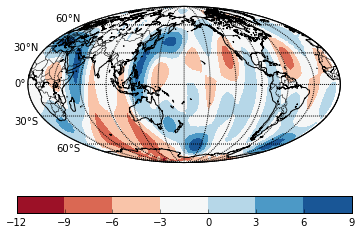

In [19]:
fig = plt.figure()
axis = fig.add_subplot(1,1,1)

map = Basemap(projection='moll', lon_0=180.0,
                  resolution='c', area_thresh=1000., ax=axis)
map.drawcoastlines()
map.drawcountries()
map.drawmapboundary()
map.drawmeridians(np.arange(-180,180,30),labels=[0,0,0,0])
map.drawparallels(np.arange(-90,90,30),labels=[1,0,0,0])

# convert lat and lon to map ref. system
lon_m, lat_m = map(model_data[:,1], model_data[:,0])

conts = map.contourf(lon_m, lat_m, filtered_data_model, tri=True, cmap=plt.cm.RdBu,)
fig.colorbar(conts, ax=axis, orientation='horizontal')

plt.show()

In [20]:
admit, corr, admit_error =  shtools.SHAdmitCorr(cilm, cilm_model)
power_spectrum_model = shtools.SHPowerSpectrum(cilm_model, 8)

In [21]:
for l in range(corr.size):
    print "For degree = {}, correlation coefficent is = {}".format(l, corr[l])

For degree = 0, correlation coefficent is = -1.0
For degree = 1, correlation coefficent is = -0.957214163965
For degree = 2, correlation coefficent is = -0.881335293968
For degree = 3, correlation coefficent is = -0.787512797301
For degree = 4, correlation coefficent is = -0.688926789939
For degree = 5, correlation coefficent is = -0.596009429778
For degree = 6, correlation coefficent is = -0.51267963104
For degree = 7, correlation coefficent is = -0.438421435604
For degree = 8, correlation coefficent is = -0.354588190411


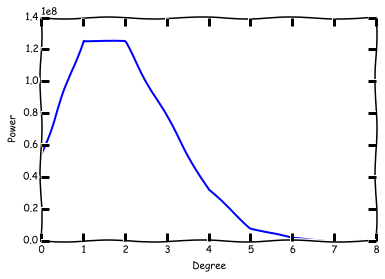

In [22]:
with plt.xkcd():
    plt.plot(power_spectrum_model)
    plt.xlabel("Degree")
    plt.ylabel("Power")